This notebook contains the network analysis of borrowing patterns among the author-members of the Shakespeare and Company lending library. The networks are constructed by connecting two author-members if they have borrowed books from the library. The networks are then analyzed to identify the most influential author-members and communities of author-members.

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx

In [176]:
member_is_author = pd.read_csv('../data/processed/table-data/01_member_is_author.csv', encoding='utf-8')
events = pd.read_csv('../data/raw/SCoData_events_v1.2_2022_01.csv', encoding='utf-8', low_memory=False)
books = pd.read_csv('../data/raw/SCoData_books_v1.2_2022_01.csv', encoding='utf-8', dtype={'year': 'Int32'})

In [177]:
member_is_author.columns

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')

In [178]:
events.columns

Index(['event_type', 'start_date', 'end_date', 'member_uris', 'member_names',
       'member_sort_names', 'subscription_price_paid', 'subscription_deposit',
       'subscription_duration', 'subscription_duration_days',
       'subscription_volumes', 'subscription_category',
       'subscription_purchase_date', 'reimbursement_refund', 'borrow_status',
       'borrow_duration_days', 'purchase_price', 'currency', 'item_uri',
       'item_title', 'item_volume', 'item_authors', 'item_year', 'item_notes',
       'source_type', 'source_citation', 'source_manifest', 'source_image'],
      dtype='object')

In [179]:
books.columns

Index(['uri', 'title', 'author', 'editor', 'translator', 'introduction',
       'illustrator', 'photographer', 'year', 'format', 'uncertain',
       'ebook_url', 'volumes_issues', 'notes', 'event_count', 'borrow_count',
       'purchase_count', 'circulation_years', 'updated'],
      dtype='object')

## Network Analysis

### Creation of Pivot Tables for Borrowing Data

*To enhance readability, the abbreviation AM in variable names denotes author-members.*

In [180]:
# Author-Member Borrows Any Title

# Filter events to include only those where the member is an author and the event type is 'Borrow'
AM_borrows = events[(events['member_sort_names'].isin(member_is_author['sort_name'])) & (events['event_type'] == 'Borrow')]

print("The unique author-members that borrowed at least one book are:")
print(AM_borrows.member_sort_names.unique())

The unique author-members that borrowed at least one book are:
['Joyce, James' 'Hemingway, Ernest' 'Schlumberger, Jean' 'Beach, Sylvia'
 'Stein, Gertrude' 'Larbaud, Valery' 'McAlmon, Robert' 'Wilson, Romer'
 'Aragon, Louis' 'Rodker, John' 'Wilder, Thornton' 'Pound, Ezra'
 'Mansfield, Katherine' 'Solano, Solita' 'de Lanux, Pierre' 'Tree, Iris'
 'Wickham, Anna' 'Wilson, Margaret' 'Le Gallienne, Richard'
 'Gilbert, Stuart' 'Boyd, James' 'Flandrau, Grace'
 'Porter, Katherine Anne' 'Lewisohn, Ludwig' 'Tate, Allen'
 'Gascoyne, David' 'Connolly, Cyril' 'Merrick, Leonard'
 'Dennis, Mary Cable' 'Rogers, Samuel' 'Guilloux, Louis'
 'Gramont, Élisabeth de' 'Ford, Ford Madox' 'Paul, Elliot'
 'Michaux, Henri' 'Wright, Richard' 'Gide, André']


In [181]:
# Author-Member Borrows Author-Member Book

# Filter events from the previous table to include only those where the author is a member
AM_borrows_AM = AM_borrows[AM_borrows.item_authors.isin(member_is_author.sort_name)]

print("The unique author-members that borrowed at least one book authored by another author-member are:")
print(AM_borrows_AM.member_sort_names.unique())

The unique author-members that borrowed at least one book authored by another author-member are:
['Joyce, James' 'Hemingway, Ernest' 'Beach, Sylvia' 'Wilson, Romer'
 'Aragon, Louis' 'Stein, Gertrude' 'Rodker, John' 'Mansfield, Katherine'
 'Solano, Solita' 'de Lanux, Pierre' 'Wickham, Anna'
 'Le Gallienne, Richard' 'Gilbert, Stuart' 'Porter, Katherine Anne'
 'Connolly, Cyril' 'Gascoyne, David' 'Dennis, Mary Cable'
 'Merrick, Leonard' 'Rogers, Samuel' 'Ford, Ford Madox' 'Paul, Elliot']


In [182]:
def create_pivot_table(data, index, columns, values=None, aggfunc='size', fill_value=0):
    """
    Creates a pivot table from a DataFrame.

    Parameters:
    - data (pd.DataFrame): The input DataFrame.
    - index (str): The column to use as rows in the pivot table.
    - columns (str): The column to use as columns in the pivot table.
    - values (str or None): The column to aggregate. Default is None for count aggregation.
    - aggfunc (str or function): The aggregation function to apply. Default is 'size'.
    - fill_value (scalar): The value to use for missing data. Default is 0.

    Returns:
    - pd.DataFrame: The resulting pivot table.
    """
    return data.pivot_table(index=index, columns=columns, values=values, aggfunc=aggfunc, fill_value=fill_value)

In [183]:
# Matrix generation | Author-Member Borrows Any Title

AM_borrows_matrix = create_pivot_table(
    data=AM_borrows, 
    index='member_sort_names', 
    columns='item_title'
)

print(AM_borrows_matrix)

item_title              A Bookman's Daybook  A Companion Volume  \
member_sort_names                                                 
Aragon, Louis                             0                   0   
Beach, Sylvia                             0                   0   
Boyd, James                               0                   0   
Connolly, Cyril                           0                   0   
Dennis, Mary Cable                        0                   0   
Flandrau, Grace                           0                   0   
Ford, Ford Madox                          0                   0   
Gascoyne, David                           0                   0   
Gide, André                               0                   0   
Gilbert, Stuart                           0                   0   
Gramont, Élisabeth de                     0                   0   
Guilloux, Louis                           0                   0   
Hemingway, Ernest                         1                   

In [184]:
# Matrix Summary | Author-Member Borrows Any Title

print(f"The matrix has {AM_borrows_matrix.shape[0]} rows and {AM_borrows_matrix.shape[1]} columns.")
print(f"The matrix includes {AM_borrows_matrix.shape[0]-1} author-members and {AM_borrows_matrix.shape[1]-1} item titles.")
print(f"Total borrow events: {AM_borrows_matrix.sum().sum()}")

The matrix has 37 rows and 734 columns.
The matrix includes 36 author-members and 733 item titles.
Total borrow events: 877


In [ ]:
# Matrix generation | Author-Member Borrows Author-Member Book

AM_borrows_AM_matrix = create_pivot_table(
    data=AM_borrows_AM, 
    index='member_sort_names', 
    columns='item_title'
)

print(AM_borrows_AM_matrix)

item_title              A Companion Volume  A Farewell to Arms  A Good Woman  \
member_sort_names                                                              
Aragon, Louis                            0                   0             0   
Beach, Sylvia                            0                   0             0   
Connolly, Cyril                          0                   0             0   
Dennis, Mary Cable                       0                   0             0   
Ford, Ford Madox                         0                   0             0   
Gascoyne, David                          0                   0             0   
Gilbert, Stuart                          0                   0             0   
Hemingway, Ernest                        0                   0             0   
Joyce, James                             0                   0             0   
Le Gallienne, Richard                    0                   1             0   
Mansfield, Katherine                    

In [186]:
# Matrix Summary | Author-Member Borrows Author-Member Book

print(f"The matrix has {AM_borrows_AM_matrix.shape[0]} rows and {AM_borrows_AM_matrix.shape[1]} columns.")
print(f"The matrix includes {AM_borrows_AM_matrix.shape[0]-1} author-members and {AM_borrows_AM_matrix.shape[1]-1} item titles.")
print(f"Total borrow events: {AM_borrows_AM_matrix.sum().sum()}")

The matrix has 21 rows and 54 columns.
The matrix includes 20 author-members and 53 item titles.
Total borrow events: 73


For reusability purposes, the matrix tables are saved as a pickle file. More on the file format can be read in the official [Python documentation](https://web.archive.org/web/20250112160715/https://docs.python.org/3/library/pickle.html).

In [187]:
AM_borrows_matrix.to_pickle(
    '../data/processed/network-matrices/04_member_borrows_author.pkl'
)

In [188]:
AM_borrows_AM_matrix.to_pickle(
    '../data/processed/network-matrices/04_member_borrows_member.pkl'
)

### Network Graph Generation for Borrowing Data

In [189]:
def create_intersection_graph(matrix, threshold=1):
    """
    Creates a graph based on the intersection of borrowed items between author-members.

    Parameters:
    - matrix (pd.DataFrame): A DataFrame where rows represent author-members and columns represent items.
      Values indicate whether an author-member borrowed an item (e.g., binary or count values).
    - threshold (int): Minimum number of common items required to create an edge.

    Returns:
    - nx.Graph: A NetworkX graph where nodes are author-members and edges are weighted by the count of common items.
    """
    # Create an empty graph
    H = nx.Graph()

    # Add nodes and edges based on the intersection of borrowed items
    for AM1 in matrix.index:
        for AM2 in matrix.index:
            if AM1 != AM2:
                # Calculate intersection of items borrowed by both users
                common_items = sum((matrix.loc[AM1] > 0) & (matrix.loc[AM2] > 0))
                if common_items >= threshold:
                    H.add_edge(AM1, AM2, weight=common_items)

    return H

Next the individual graphs are created and the number of edges and nodes is calculated.

In [190]:
# Graph generation | Author-Member Borrows Any Title

AM_borrows_graph = create_intersection_graph(AM_borrows_matrix)
print("Graph 'Member borrows Author' - Number of nodes:", AM_borrows_graph.number_of_nodes())
print("Graph 'Member borrows Author' - Number of edges:", AM_borrows_graph.number_of_edges())

Graph 'Member borrows Author' - Number of nodes: 25
Graph 'Member borrows Author' - Number of edges: 58


In [191]:
# Graph generation | Author-Member Borrows Author-Member Book

AM_borrows_AM_graph = create_intersection_graph(AM_borrows_AM_matrix)
print("Graph 'Member borrows Member' - Number of nodes:", AM_borrows_AM_graph.number_of_nodes())
print("Graph 'Member borrows Member' - Number of edges:", AM_borrows_AM_graph.number_of_edges())

Graph 'Member borrows Member' - Number of nodes: 14
Graph 'Member borrows Member' - Number of edges: 18


In this network, each node (person) represents an individual who borrowed books.
An edge between two nodes indicates that these two individuals have borrowed at least one book in common.

In [192]:
def plot_network(X, use_weight=True, k=None, titleAdd=None, node_color='thistle', label_weights=False, figure_name=None):
    """
    Plots a graph with optional edge weights and customizable node colors.

    Parameters:
    - X (networkx.Graph): The input graph.
    - use_weight (bool): If True, scales edge widths by the weight attribute.
    - k (float): The optimal distance between nodes for the layout.
    - titleAdd (str): Additional text for the title.
    - node_color (str or list): The color of the nodes. Can be a single color or a list of colors.
    - label_weights (bool): If True, labels the edges with their weights.
    """
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(X, seed=42, k=k)

    # Check if node_color is a list/array (i.e., for clustering) or a single color
    if isinstance(node_color, str):
        # Use a single color for all nodes
        nx.draw_networkx_nodes(X, pos, node_size=600, node_color=node_color)
    else:
        # Use colormap for clustering
        nx.draw_networkx_nodes(X, pos, node_size=600, node_color=node_color, cmap=plt.cm.viridis)

    if use_weight:
        weights = [X[u][v].get('weight', 1) for u, v in X.edges()]
        nx.draw_networkx_edges(X, pos, width=weights, alpha=0.5)
    else:
        nx.draw_networkx_edges(X, pos, alpha=0.5)

    # Draw labels with a bounding box to avoid overlap
    labels = nx.draw_networkx_labels(X, pos, font_size=10, font_family='sans-serif',
                                     bbox=dict(facecolor='white', boxstyle='round,pad=0.3'))

    # Adjust label positions to avoid overlap
    for _, t in labels.items():
        t.set_bbox(dict(facecolor='white', boxstyle='round,pad=0.3', alpha=0.7, edgecolor='none'))

    # Optionally label the weights on the edges
    if label_weights:
        edge_labels = nx.get_edge_attributes(X, 'weight')
        nx.draw_networkx_edge_labels(X, pos, edge_labels=edge_labels, font_size=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

    # Ensure all labels are visible and not cut off by the border
    plt.margins(0.1)
    plt.title(titleAdd, fontsize=16, fontweight='bold')
    # Disable the grid
    plt.grid(False)
    plt.tight_layout()

    plt.savefig(f'../data/processed/figure-images/04_graph_{figure_name}.png',bbox_inches='tight')

    plt.show()

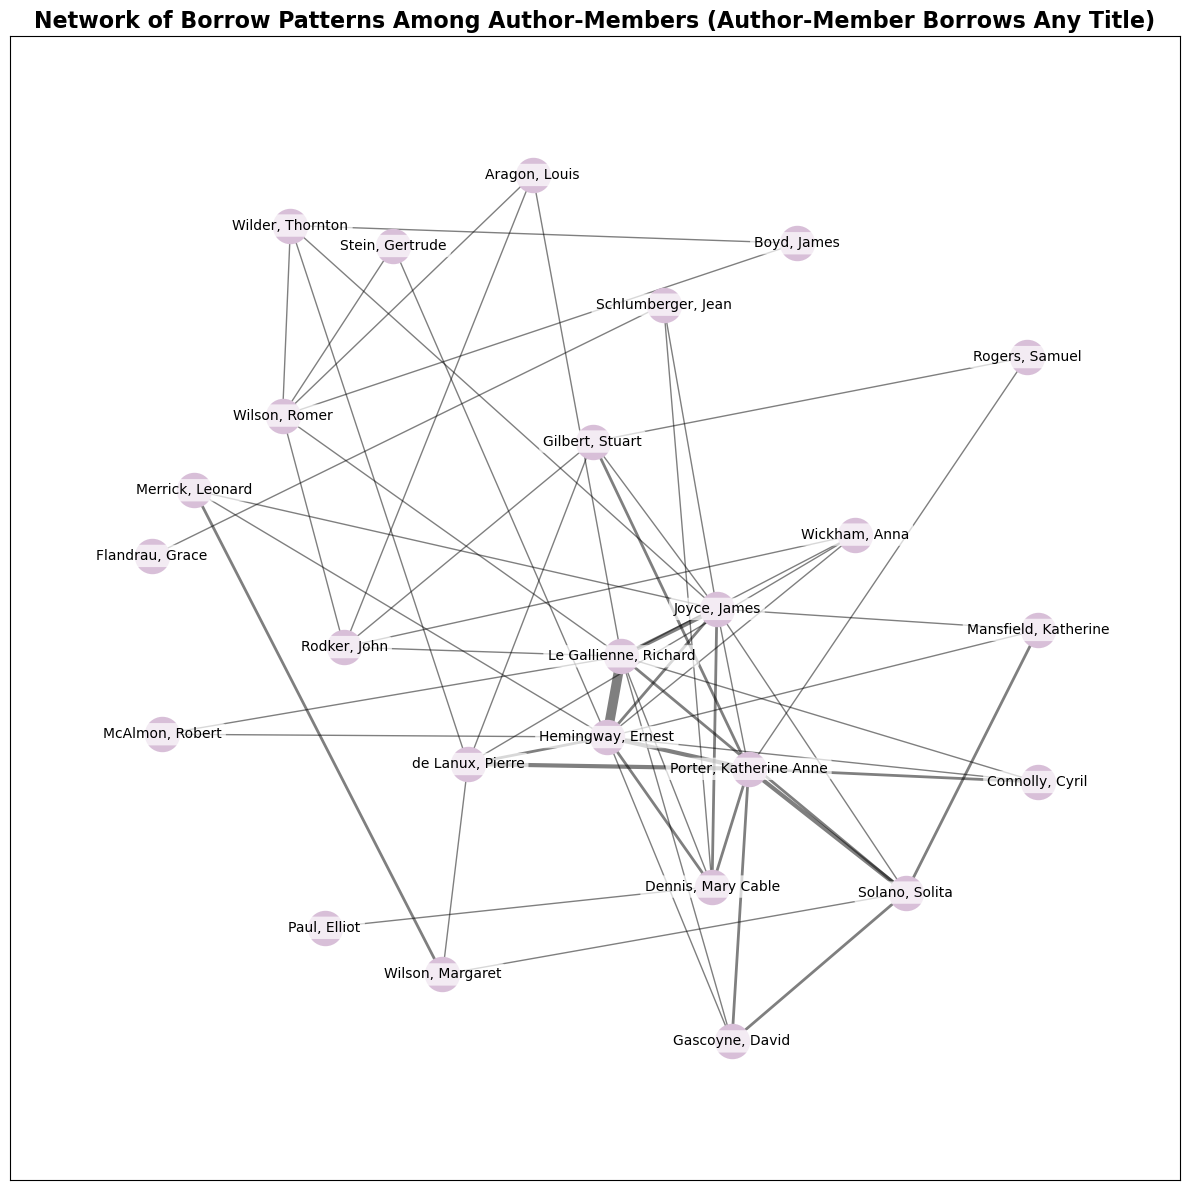

In [193]:
# Network visualization | Author-Member Borrows Any Title

plot_network(AM_borrows_graph, k=1.7, titleAdd='Network of Borrow Patterns Among Author-Members (Author-Member Borrows Any Title)',figure_name='member_borrows_author')

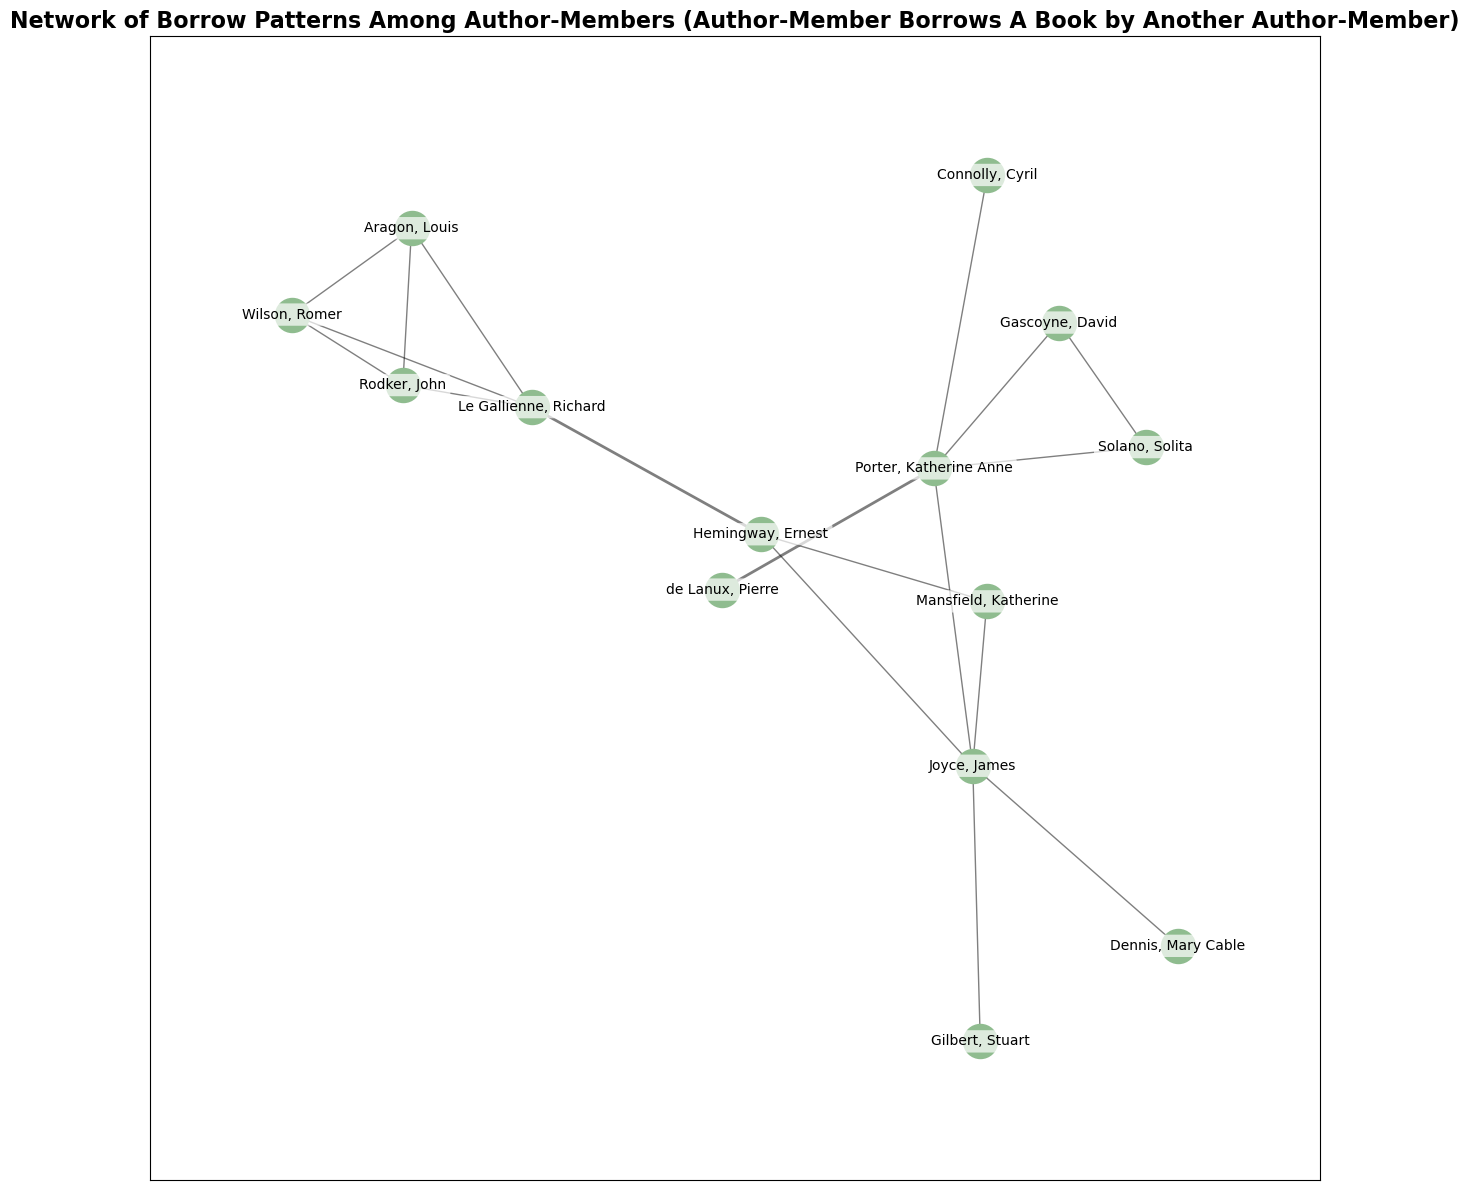

In [ ]:
# Network visualization | Author-Member Borrows Author-Member Book

plot_network(AM_borrows_AM_graph, use_weight=True, k=0.67, titleAdd='Network of Borrow Patterns Among Author-Members (Author-Member Borrows A Book by Another Author-Member)', node_color='darkseagreen', figure_name='member_borrows_member')

### Network Metrics

In [195]:
def plot_graph_metric(metric_dict, x_label, y_label, title=None, rotation=90, ylim=None, figure_name=None):
    """
    Plots a bar chart for a given graph metric after sorting the values.

    Parameters:
    metric_dict (dict): A dictionary where keys are nodes and values are the metric to plot.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str, optional): Title of the plot. Defaults to None.
    rotation (int, optional): Rotation angle for x-axis labels. Defaults to 90.
    ylim (tuple, optional): Limits for the y-axis. Defaults to None.
    figure_name (str, optional): Name for the saved figure file. Defaults to None.

    Returns:
    None
    """
    # Sort the dictionary by its values in descending order
    sorted_items = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_keys = [item[0] for item in sorted_items]
    sorted_values = [item[1] for item in sorted_items]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(sorted_keys)), sorted_values, align='center', color='cornflowerblue')
    plt.xticks(range(len(sorted_keys)), sorted_keys, rotation=rotation)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Set y-axis limits; if none are provided, automatically set the upper limit slightly above the maximum value
    if ylim:
        plt.ylim(ylim)
    else:
        plt.ylim(0, max(sorted_values) + 1)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save the figure if a figure name is provided
    if figure_name:
        plt.savefig(f'../data/processed/figure-images/04_bar_{figure_name}.png', bbox_inches='tight')
    
    plt.show()

In [196]:
def plot_side_by_side_graph_metrics(weighted_dict, unweighted_dict, x_label, y_label, title=None, rotation=90, ylim=None, figure_name=None):
    """
    Plots a side-by-side bar chart for weighted and unweighted graph metrics after sorting the nodes by weighted degree.

    Parameters:
    weighted_dict (dict): A dictionary where keys are nodes and values are the weighted degree.
    unweighted_dict (dict): A dictionary where keys are nodes and values are the unweighted degree.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str, optional): Title of the plot. Defaults to None.
    rotation (int, optional): Rotation angle for x-axis labels. Defaults to 90.
    ylim (tuple, optional): Limits for the y-axis. Defaults to None.
    figure_name (str, optional): Name for the saved figure file. Defaults to None

    Returns:
    None
    """
    # Sort the nodes based on weighted degree values in descending order.
    sorted_nodes = sorted(weighted_dict.keys(), key=lambda node: weighted_dict[node], reverse=True)
    
    # Alternative sorting logic: by the sum of weighted and unweighted degrees:
    # sorted_nodes = sorted(weighted_dict.keys(), key=lambda node: weighted_dict[node] + unweighted_dict[node], reverse=True)
    
    # Extract the sorted values for both metrics
    weighted_values = [weighted_dict[node] for node in sorted_nodes]
    unweighted_values = [unweighted_dict[node] for node in sorted_nodes]

    # Determine x positions and bar width
    x = np.arange(len(sorted_nodes))
    width = 0.4

    plt.figure(figsize=(12, 6))

    # Plot the unweighted and weighted degrees side by side
    unweighted_bars = plt.bar(x - width / 2, unweighted_values, width=width, label='Unweighted Degree', color='lightblue')
    weighted_bars = plt.bar(x + width / 2, weighted_values, width=width, label='Weighted Degree', color='cornflowerblue')

    # Set the x-tick labels to the sorted nodes
    plt.xticks(x, sorted_nodes, rotation=rotation)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Set y-axis limits; if not specified, use the maximum value among both metrics
    if ylim:
        plt.ylim(ylim)
    else:
        plt.ylim(0, max(max(weighted_values), max(unweighted_values)) + 1)
    
    plt.title(title, fontsize=16, fontweight='bold')
    
    # Add a grid for the x-axis to improve readability
    plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Include a legend to distinguish between the two metrics
    plt.legend(handles=[unweighted_bars, weighted_bars])
    
    plt.tight_layout()
    
    # Save the figure
    if figure_name:
        plt.savefig(f'../data/processed/figure-images/04_bar_{figure_name}.png', bbox_inches='tight')
    
    plt.show()

Now the weighted and unweighted degree centrality are calculated.

In [197]:
# Degree distribution | Author-Member Borrows Any Title

AM_borrows_unweighted_degree = dict(AM_borrows_graph.degree())

AM_borrows_weighted_degree = dict(AM_borrows_graph.degree(weight="weight"))

print("Degree distribution for AM_borrows_graph:")

# Unweighted Degree

print('Unweighted Degree:',sorted(AM_borrows_unweighted_degree.items(), key=lambda x:x[1], reverse=True))

# Weighted Degree

print('Weighted Degree:',sorted(AM_borrows_weighted_degree.items(), key=lambda x:x[1], reverse=True))

Degree distribution for AM_borrows_graph:
Unweighted Degree: [('Hemingway, Ernest', 12), ('Le Gallienne, Richard', 11), ('Joyce, James', 10), ('Porter, Katherine Anne', 9), ('Wilson, Romer', 6), ('Dennis, Mary Cable', 6), ('Solano, Solita', 6), ('de Lanux, Pierre', 6), ('Rodker, John', 5), ('Gilbert, Stuart', 5), ('Wilder, Thornton', 4), ('Gascoyne, David', 4), ('Wickham, Anna', 4), ('Aragon, Louis', 3), ('Connolly, Cyril', 3), ('Schlumberger, Jean', 3), ('Mansfield, Katherine', 3), ('Merrick, Leonard', 3), ('Wilson, Margaret', 3), ('Boyd, James', 2), ('Rogers, Samuel', 2), ('McAlmon, Robert', 2), ('Stein, Gertrude', 2), ('Paul, Elliot', 1), ('Flandrau, Grace', 1)]
Weighted Degree: [('Hemingway, Ernest', 23), ('Le Gallienne, Richard', 20), ('Porter, Katherine Anne', 19), ('Joyce, James', 14), ('Solano, Solita', 11), ('Dennis, Mary Cable', 9), ('de Lanux, Pierre', 9), ('Wilson, Romer', 6), ('Gascoyne, David', 6), ('Gilbert, Stuart', 6), ('Rodker, John', 5), ('Wilder, Thornton', 4), ('Co

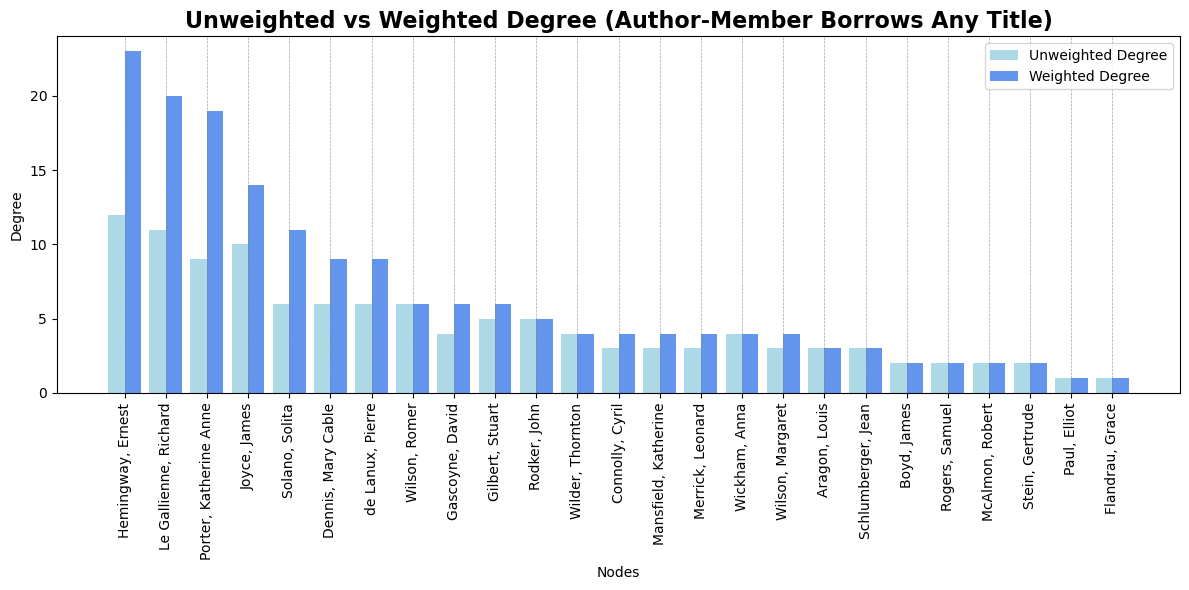

In [198]:
# Plot: Degree distribution | Author-Member Borrows Any Title

plot_side_by_side_graph_metrics(AM_borrows_weighted_degree,
    AM_borrows_unweighted_degree,
    x_label="Nodes",
    y_label="Degree",
    title="Unweighted vs Weighted Degree (Author-Member Borrows Any Title)",
    rotation=90,
    figure_name='AM_borrows_degree')

In [199]:
# Degree distribution | Author-Member Borrows Author-Member Book

AM_borrows_AM_unweighted_degree = dict(AM_borrows_AM_graph.degree())

AM_borrows_AM_weighted_degree = dict(AM_borrows_AM_graph.degree(weight="weight"))

print("Degree distribution for AM_borrows_AM_graph:")

# Unweighted Degree

print('Unweighted Degree:',sorted(AM_borrows_AM_unweighted_degree.items(), key=lambda x:x[1], reverse=True))

# Weighted Degree

print('Weighted Degree:',sorted(AM_borrows_AM_weighted_degree.items(), key=lambda x:x[1], reverse=True))

Degree distribution for AM_borrows_AM_graph:
Unweighted Degree: [('Porter, Katherine Anne', 5), ('Joyce, James', 5), ('Le Gallienne, Richard', 4), ('Aragon, Louis', 3), ('Rodker, John', 3), ('Wilson, Romer', 3), ('Hemingway, Ernest', 3), ('Gascoyne, David', 2), ('Solano, Solita', 2), ('Mansfield, Katherine', 2), ('Connolly, Cyril', 1), ('Dennis, Mary Cable', 1), ('Gilbert, Stuart', 1), ('de Lanux, Pierre', 1)]
Weighted Degree: [('Porter, Katherine Anne', 6), ('Le Gallienne, Richard', 5), ('Joyce, James', 5), ('Hemingway, Ernest', 4), ('Aragon, Louis', 3), ('Rodker, John', 3), ('Wilson, Romer', 3), ('Gascoyne, David', 2), ('Solano, Solita', 2), ('Mansfield, Katherine', 2), ('de Lanux, Pierre', 2), ('Connolly, Cyril', 1), ('Dennis, Mary Cable', 1), ('Gilbert, Stuart', 1)]


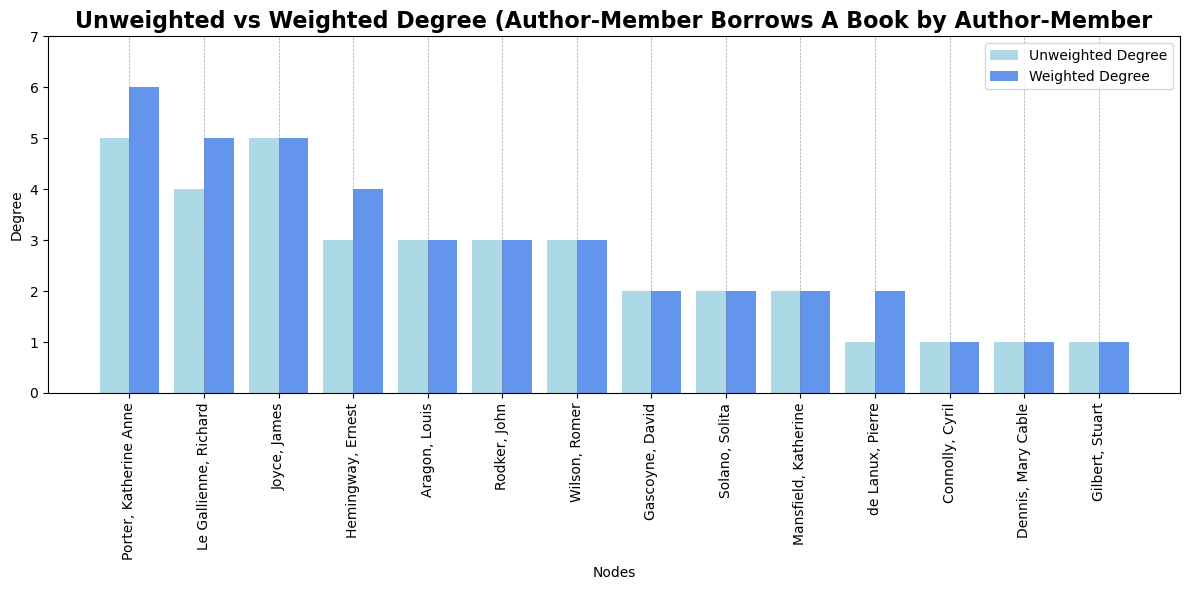

In [200]:
# Plot: Degree distribution | Author-Member Borrows Author-Member Book

plot_side_by_side_graph_metrics(AM_borrows_AM_weighted_degree,
    AM_borrows_AM_unweighted_degree,
    x_label="Nodes",                            y_label="Degree",
    title="Unweighted vs Weighted Degree (Author-Member Borrows A Book by Author-Member",                            
    rotation=90,
    figure_name='AM_borrows_AM_degree')

#### Clustering Coefficient

In [201]:
# Clustering Coefficient | Author-Member Borrows Any Title

AM_borrows_coefficient = nx.clustering(AM_borrows_graph)

print("Clustering Coefficient for AM_borrows_graph:")
# sort the dictionary by its values in descending order
print(dict(sorted(AM_borrows_coefficient.items(), key=lambda x: x[1], reverse=True)))

Clustering Coefficient for AM_borrows_graph:
{'Aragon, Louis': 1.0, 'Boyd, James': 1.0, 'Rogers, Samuel': 1.0, 'McAlmon, Robert': 1.0, 'Connolly, Cyril': 0.6666666666666666, 'Gascoyne, David': 0.6666666666666666, 'Mansfield, Katherine': 0.6666666666666666, 'Wickham, Anna': 0.5, 'Rodker, John': 0.4, 'Dennis, Mary Cable': 0.4, 'Schlumberger, Jean': 0.3333333333333333, 'Solano, Solita': 0.3333333333333333, 'Merrick, Leonard': 0.3333333333333333, 'Porter, Katherine Anne': 0.3055555555555556, 'Gilbert, Stuart': 0.3, 'Wilson, Romer': 0.26666666666666666, 'Joyce, James': 0.26666666666666666, 'Le Gallienne, Richard': 0.23636363636363636, 'Hemingway, Ernest': 0.22727272727272727, 'de Lanux, Pierre': 0.2, 'Wilder, Thornton': 0.16666666666666666, 'Paul, Elliot': 0, 'Flandrau, Grace': 0, 'Stein, Gertrude': 0, 'Wilson, Margaret': 0}


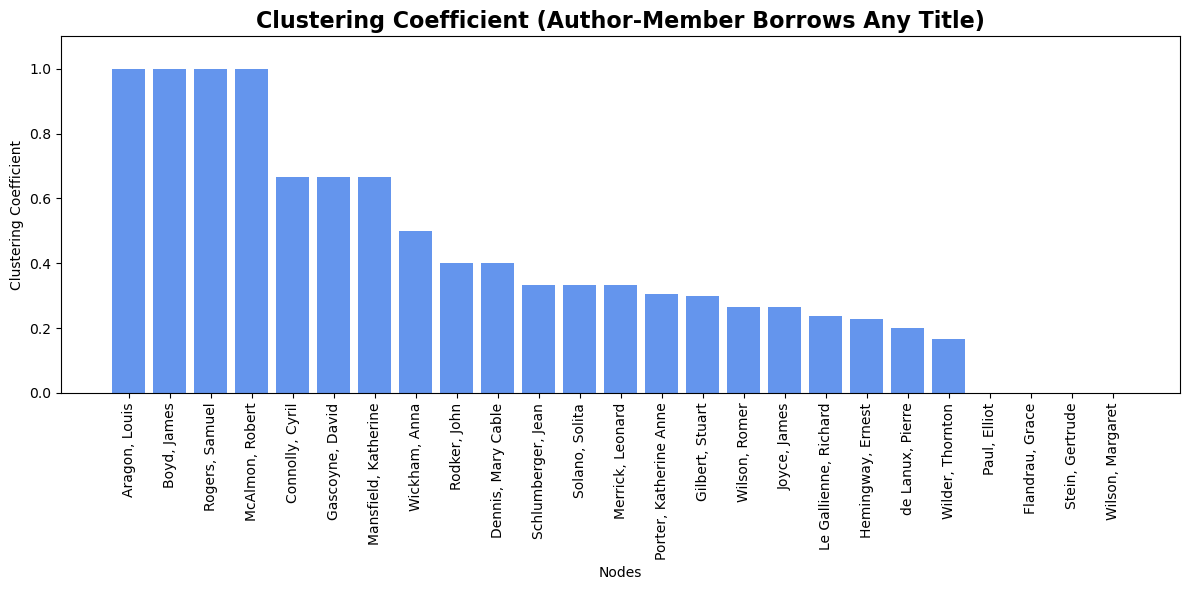

In [202]:
plot_graph_metric(AM_borrows_coefficient, x_label="Nodes", y_label="Clustering Coefficient", title="Clustering Coefficient (Author-Member Borrows Any Title)", ylim=(0, 1.1), figure_name='AM_borrows_coefficient')

In [203]:
# Clustering Coefficient | Author-Member Borrows Author-Member Book

AM_borrows_AM_coefficient = nx.clustering(AM_borrows_AM_graph)

print("Clustering Coefficient for AM_borrows_AM_graph:")
# sort the dictionary by its values in descending order
print(dict(sorted(AM_borrows_AM_coefficient.items(), key=lambda x: x[1], reverse=True)))

Clustering Coefficient for AM_borrows_AM_graph:
{'Aragon, Louis': 1.0, 'Rodker, John': 1.0, 'Wilson, Romer': 1.0, 'Gascoyne, David': 1.0, 'Solano, Solita': 1.0, 'Mansfield, Katherine': 1.0, 'Le Gallienne, Richard': 0.5, 'Hemingway, Ernest': 0.3333333333333333, 'Porter, Katherine Anne': 0.1, 'Joyce, James': 0.1, 'Connolly, Cyril': 0, 'Dennis, Mary Cable': 0, 'Gilbert, Stuart': 0, 'de Lanux, Pierre': 0}


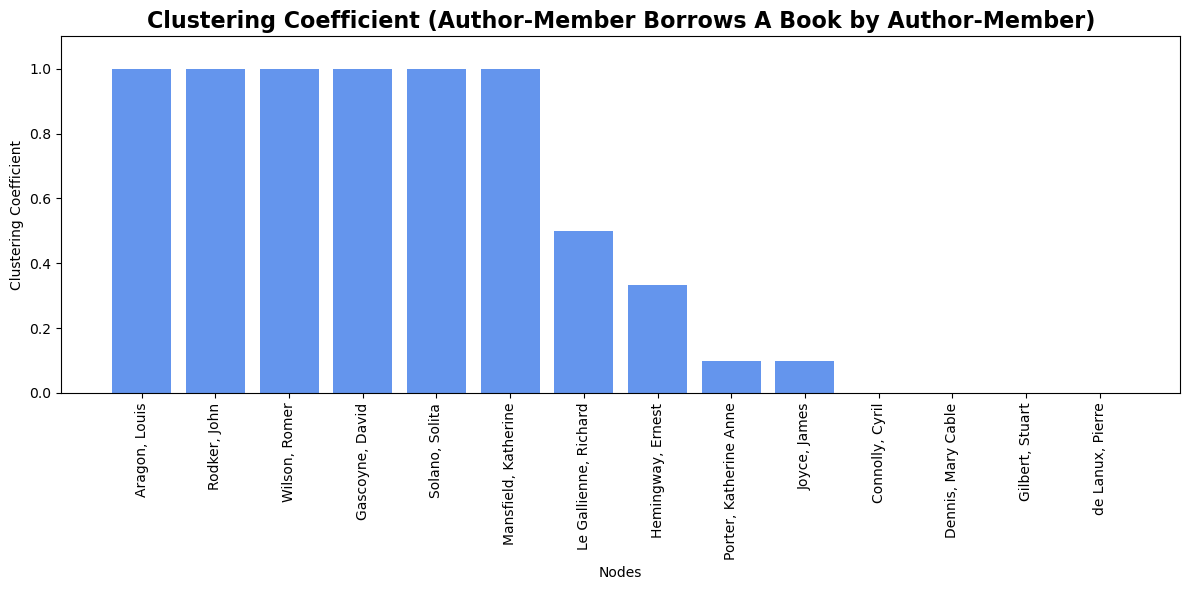

In [204]:
plot_graph_metric(AM_borrows_AM_coefficient, x_label="Nodes", y_label="Clustering Coefficient", title="Clustering Coefficient (Author-Member Borrows A Book by Author-Member)", ylim=(0, 1.1), figure_name='AM_borrows_AM_coefficient')

#### Density

In [205]:
# Density | Author-Member Borrows Any Title
AM_borrows_density = nx.density(AM_borrows_graph)

print(f"Density: {round(AM_borrows_density, 3)}")

Density: 0.193


In [206]:
# Density | Author-Member Borrows Author-Member Book
AM_borrows_AM_density = nx.density(AM_borrows_AM_graph)

print(f"Density: {round(AM_borrows_AM_density, 3)}")

Density: 0.198


#### Diameter

In [207]:
# Diameter | Author-Member Borrows Any Title
AM_borrows_diameter = nx.diameter(AM_borrows_graph)

print(f"Diameter: {AM_borrows_diameter}")

Diameter: 4


In [208]:
# Diameter | Author-Member Borrows Author-Member Book
AM_borrows_AM_diameter = nx.diameter(AM_borrows_AM_graph)

print(f"Diameter: {AM_borrows_AM_diameter}")

Diameter: 5


#### Average Shortest Path Length

In [209]:
# Average shortest path length | Author-Member Borrows Any Title
AM_borrows_shortest_path = nx.average_shortest_path_length(AM_borrows_graph)

print(f"Average shortest path length: {round(AM_borrows_shortest_path, 3)}")

Average shortest path length: 2.173


In [210]:
# Average shortest path length | Author-Member Borrows Author-Member Book
AM_borrows_AM_shortest_path = nx.average_shortest_path_length(AM_borrows_AM_graph)

print(f"Average shortest path length: {round(AM_borrows_AM_shortest_path, 3)}")

Average shortest path length: 2.758


#### Assortativity

In [211]:
# Assortativity | Author-Member Borrows Any Title
AM_borrows_assortativity = nx.assortativity.degree_assortativity_coefficient(AM_borrows_graph)

print(f"Assortativity: {round(AM_borrows_assortativity, 3)}")

Assortativity: -0.23


In [212]:
# Assortativity | Author-Member Borrows Author-Member Book
AM_borrows_AM_assortativity = nx.assortativity.degree_assortativity_coefficient(AM_borrows_AM_graph)

print(f"Assortativity: {round(AM_borrows_AM_assortativity, 3)}")

Assortativity: -0.582


#### Average Clustering Coefficient

In [213]:
# Average clustering coefficient | Author-Member Borrows Any Title
AM_borrows_avg_coefficient = nx.average_clustering(AM_borrows_graph)

print(f"Average clustering coefficient: {round(AM_borrows_avg_coefficient, 3)}")

Average clustering coefficient: 0.411


In [214]:
# Average clustering coefficient | Author-Member Borrows Author-Member Book
AM_borrows_AM_avg_coefficient = nx.average_clustering(AM_borrows_AM_graph)

print(f"Average clustering coefficient: {round(AM_borrows_AM_avg_coefficient, 3)}")

Average clustering coefficient: 0.502


#### Small World

In [215]:
# Small-worldness | Author-Member Borrows Any Title

AM_borrows_small_world = AM_borrows_avg_coefficient/AM_borrows_shortest_path

print(f"Small world: {round(AM_borrows_small_world, 3)}")

AM_borrows_sigma = nx.algorithms.smallworld.sigma(AM_borrows_graph,niter=10,nrand=5) # Note: the sigma value is calculated using 10 iterations and 5 randomizations -> output values differ each time the function is called

print(f"Sigma value: {round(AM_borrows_sigma, 3)}")

Small world: 0.189
Sigma value: 1.101


In [ ]:
# Small-worldness | Author-Member Borrows Author-Member Book

AM_borrows_AM_small_world = AM_borrows_AM_avg_coefficient/AM_borrows_AM_shortest_path

print(f"Small world: {round(AM_borrows_AM_small_world, 3)}")

AM_borrows_AM_sigma = nx.algorithms.smallworld.sigma(AM_borrows_AM_graph,niter=10,nrand=5) # Note: the sigma value is calculated using 10 iterations and 5 randomizations -> output values differ each time the function is called

print(f"Sigma value: {round(AM_borrows_AM_sigma, 3)}")

Small world: 0.182
Sigma value: 1.912


#### Cliques

In [217]:
# Cliques | Author-Member Borrows Any Title

AM_borrows_clique = list(nx.clique.find_cliques(AM_borrows_graph))

# Maximum clique size
AM_borrows_clique_max_size = max(len(clique) for clique in AM_borrows_clique)

# Maximum cliques
AM_borrows_max_cliques = [clique for clique in AM_borrows_clique if len(clique) == AM_borrows_clique_max_size]

print('Number of cliques:', len(AM_borrows_clique))
print('Number of maximum cliques:', len(AM_borrows_max_cliques))
print('Maximum clique:', AM_borrows_max_cliques)
print('All cliques:', AM_borrows_clique)

Number of cliques: 34
Number of maximum cliques: 3
Maximum clique: [['Wilson, Romer', 'Aragon, Louis', 'Le Gallienne, Richard', 'Rodker, John'], ['Hemingway, Ernest', 'Porter, Katherine Anne', 'Joyce, James', 'Dennis, Mary Cable'], ['Hemingway, Ernest', 'Le Gallienne, Richard', 'Joyce, James', 'Dennis, Mary Cable']]
All cliques: [['Boyd, James', 'Wilson, Romer', 'Wilder, Thornton'], ['Wilson, Margaret', 'de Lanux, Pierre'], ['Wilson, Margaret', 'Merrick, Leonard'], ['Wilson, Margaret', 'Solano, Solita'], ['Flandrau, Grace', 'Schlumberger, Jean'], ['Solano, Solita', 'Joyce, James', 'Le Gallienne, Richard'], ['Solano, Solita', 'Joyce, James', 'Porter, Katherine Anne'], ['Solano, Solita', 'Joyce, James', 'Mansfield, Katherine'], ['Solano, Solita', 'Gascoyne, David', 'Le Gallienne, Richard'], ['Solano, Solita', 'Gascoyne, David', 'Porter, Katherine Anne'], ['Wilson, Romer', 'Stein, Gertrude'], ['Wilson, Romer', 'Aragon, Louis', 'Le Gallienne, Richard', 'Rodker, John'], ['Wilder, Thornton',

In [218]:
# Cliques | Author-Member Borrows Author-Member Book

AM_borrows_AM_clique = list(nx.clique.find_cliques(AM_borrows_AM_graph))

# Maximum clique size
AM_borrows_AM_clique_max_size = max(len(clique) for clique in AM_borrows_AM_clique)

# Maximum cliques
AM_borrows_AM_max_cliques = [clique for clique in AM_borrows_AM_clique if len(clique) == AM_borrows_AM_clique_max_size]

print('Number of cliques:', len(AM_borrows_AM_clique))
print('Number of maximum cliques:', len(AM_borrows_AM_max_cliques))
print('Maximum clique:', max(AM_borrows_AM_clique, key=len))
print('All cliques:', AM_borrows_AM_clique)

Number of cliques: 9
Number of maximum cliques: 1
Maximum clique: ['Wilson, Romer', 'Le Gallienne, Richard', 'Aragon, Louis', 'Rodker, John']
All cliques: [['Joyce, James', 'Gilbert, Stuart'], ['Joyce, James', 'Hemingway, Ernest', 'Mansfield, Katherine'], ['Joyce, James', 'Dennis, Mary Cable'], ['Joyce, James', 'Porter, Katherine Anne'], ['Solano, Solita', 'Gascoyne, David', 'Porter, Katherine Anne'], ['Wilson, Romer', 'Le Gallienne, Richard', 'Aragon, Louis', 'Rodker, John'], ['Connolly, Cyril', 'Porter, Katherine Anne'], ['de Lanux, Pierre', 'Porter, Katherine Anne'], ['Le Gallienne, Richard', 'Hemingway, Ernest']]


#### Communities

In [219]:
def get_node_colors_by_clustering(graph, clustering_algorithm):
    """
    Applies a clustering algorithm to the graph and returns node colors.

    Parameters:
    - graph (networkx.Graph): The input graph.
    - clustering_algorithm (function): The clustering algorithm to apply. 
      It should return a list of sets, where each set contains the nodes in a cluster.

    Returns:
    - list: A list of colors (one per node) representing cluster membership.
    """
    communities = list(clustering_algorithm(graph))  # Apply the clustering algorithm
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}
    return [community_map[node] for node in graph.nodes()]

##### Louvain

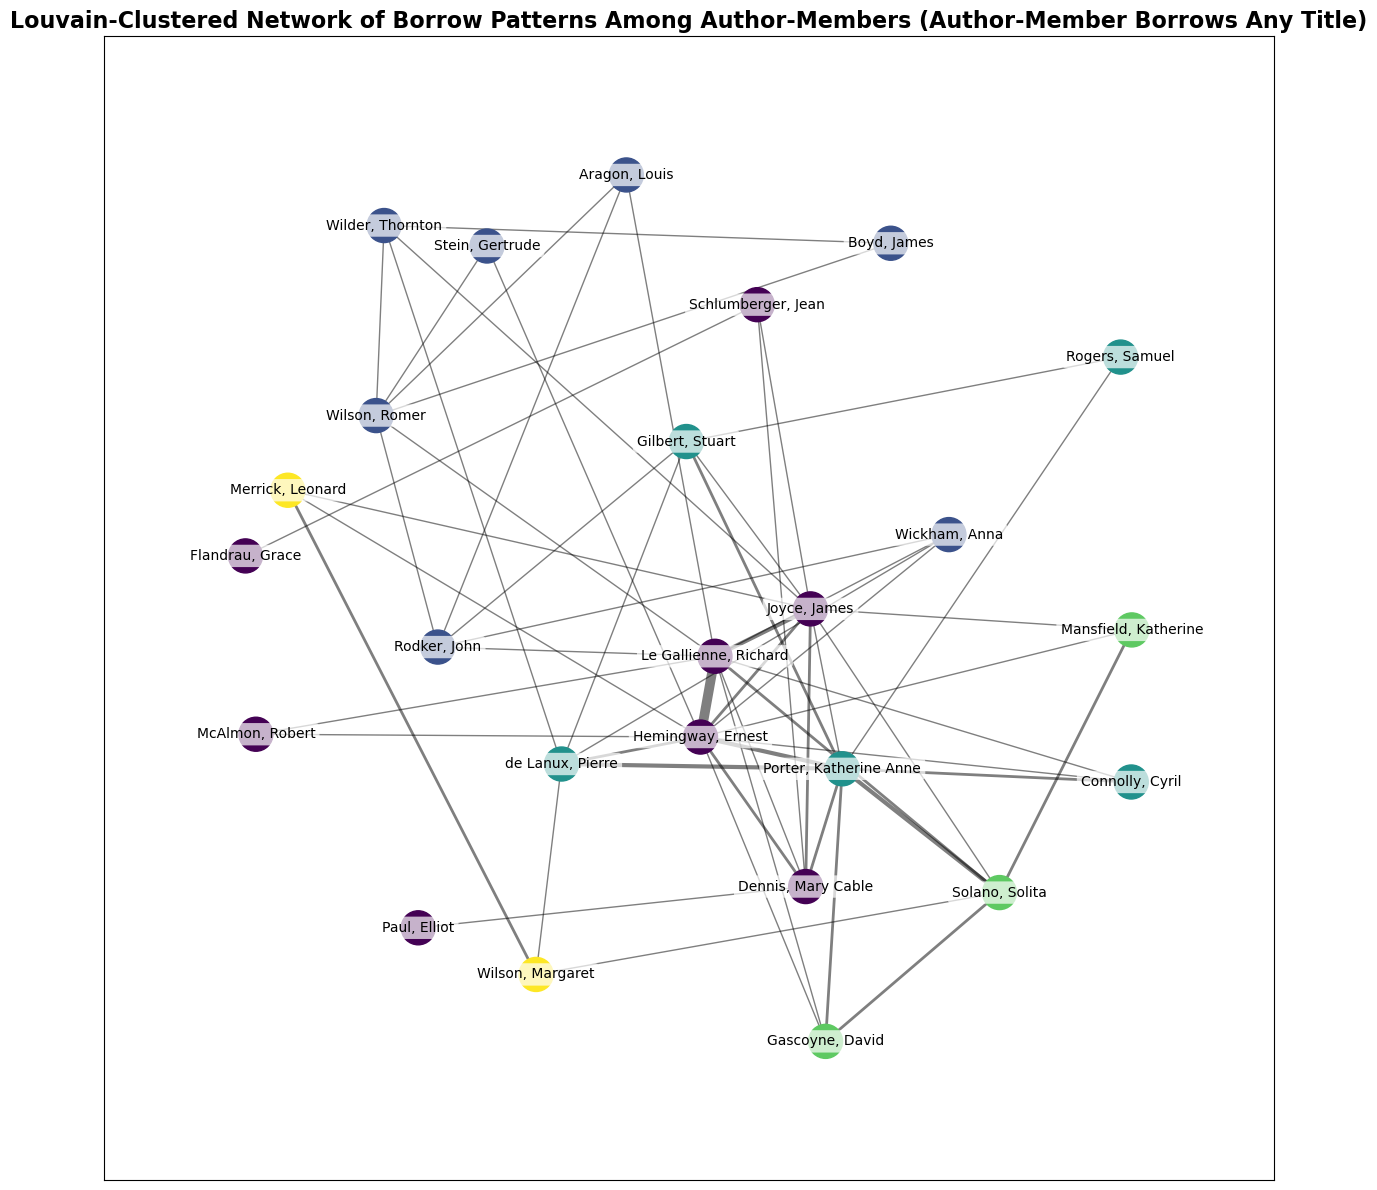

In [230]:
# Clustering with Louvain
AM_borrows_louvain = get_node_colors_by_clustering(AM_borrows_graph, nx.community.louvain_communities)

# Plot with Louvain
plot_network(AM_borrows_graph, titleAdd='Louvain-Clustered Network of Borrow Patterns Among Author-Members (Author-Member Borrows Any Title)', k=1.7,node_color=AM_borrows_louvain, figure_name='AM_borrows_louvain')

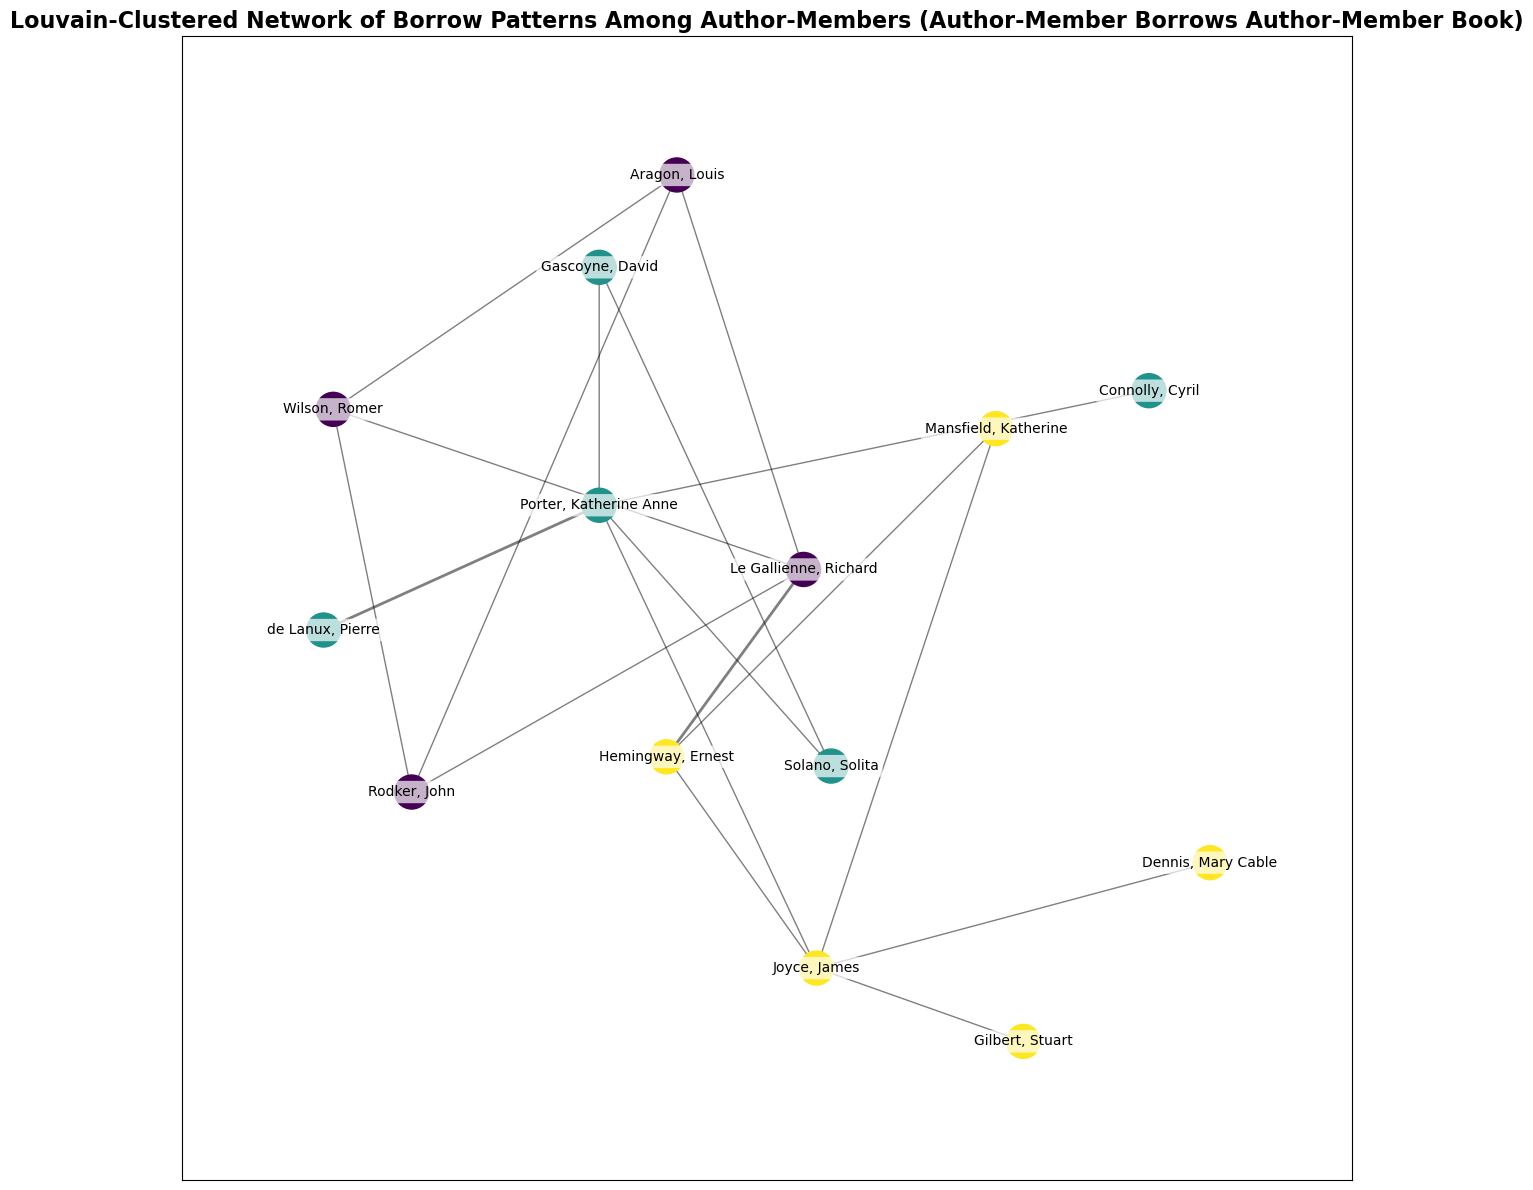

In [229]:
# Clustering with Louvain
AM_borrows_AM_louvain = get_node_colors_by_clustering(AM_borrows_AM_graph, nx.community.louvain_communities)

# Plot with Louvain
plot_network(AM_borrows_AM_graph, titleAdd='Louvain-Clustered Network of Borrow Patterns Among Author-Members (Author-Member Borrows Author-Member Book)', k=1.7,node_color=AM_borrows_AM_louvain, figure_name='AM_borrows_AM_louvain')

#### Network Graph: Books and Author-Members

In [ ]:
def compute_borrow_counts(matrix, top_n=25):
    """
    Computes the total borrow count for each book and displays the top borrowed books.

    Parameters:
        matrix (DataFrame): The user-book or member-book matrix.
        books (DataFrame): The books dataset containing 'title', 'author', and 'format' columns.
        top_n (int): Number of top borrowed books to display.

    Returns:
        DataFrame: A DataFrame with columns ['book_title', 'author', 'borrow_count'] sorted by borrow count.
    """
    # Sum the borrow counts across all users/members
    borrow_counts = matrix.sum(axis=0).reset_index()
    borrow_counts.columns = ['book_title', 'borrow_count']
    
    # Merge with the books dataset to include the author column
    borrow_counts = borrow_counts.merge(books[['title', 'author']], left_on='book_title', right_on='title', how='left')
    borrow_counts = borrow_counts[['book_title', 'author', 'borrow_count']]
    
    # Display the top N most borrowed books
    top_borrowed = borrow_counts.sort_values(by='borrow_count', ascending=False).head(top_n)
    
    return top_borrowed

In [66]:
# Top borrowed books | Author-Member Borrows Any Title

AM_borrows_count = compute_borrow_counts(AM_borrows_matrix).reset_index(drop=True)

print(AM_borrows_count)

# Save the counts to a CSV file
AM_borrows_count.to_csv(
    '../data/processed/table-data/04_AM_borrows_counts.csv',
    encoding='utf-8'
)

                                           book_title  \
0                       Saturday Review of Literature   
1                                          transition   
2                           Thomas De Quincey's Works   
3                                            The Dial   
4             A Portrait of the Artist as a Young Man   
5                                          New Masses   
6                                        Hound & Horn   
7                                               Broom   
8                    The Symposium: A Critical Review   
9                                  A Companion Volume   
10                                   The New Republic   
11                                        Three Lives   
12                                      Warrant for X   
13               The Autobiography of Alice B. Toklas   
14                                       And Even Now   
15  The Works of Sterne: The Life and Opinions of ...   
16                             

In [67]:
# Top borrowed books | Author-Member Borrows Author-Member Book

AM_borrows_AM_count = compute_borrow_counts(AM_borrows_AM_matrix).reset_index(drop=True)

print(AM_borrows_AM_count)

# Save the counts to a CSV file
AM_borrows_AM_count.to_csv(
    '../data/processed/table-data/04_AM_borrows_AM_counts.csv',
    encoding='utf-8'
)

                                           book_title                  author  \
0             A Portrait of the Artist as a Young Man            Joyce, James   
1                                  A Companion Volume         McAlmon, Robert   
2                The Autobiography of Alice B. Toklas         Stein, Gertrude   
3                                         Three Lives         Stein, Gertrude   
4                                  A Mirror to France        Ford, Ford Madox   
5   To Return to Yesterday: Reminiscences 1894 – 1914        Ford, Ford Madox   
6   Back to Montparnasse: Glimpses of Broadway in ...      Huddleston, Sisley   
7               Oscar Wilde: His Life and Confessions           Harris, Frank   
8                              Death in the Afternoon       Hemingway, Ernest   
9                 Distinguished Air: Grim Fairy Tales         McAlmon, Robert   
10                              This Side of Paradise    Fitzgerald, F. Scott   
11                          

In [68]:
# Members by Title | Author-Member Borrows Any Title

# extract the members that borrowed a specific title
AM_borrows_matrix[AM_borrows_matrix['Three Lives'] > 0].index

Index(['Hemingway, Ernest', 'Joyce, James', 'Mansfield, Katherine'], dtype='object', name='member_sort_names')

In [53]:
def create_edge_list(pivot_table, min_borrow_count=1):
    """
    Converts a pivot table to an edge list and filters out books borrowed less than a specified number of times.

    Parameters:
    pivot_table (pd.DataFrame): A pivot table with members and items.
    min_borrow_count (int): Minimum number of times a book should be borrowed to be included. Default is 1.

    Returns:
    pd.DataFrame: Filtered edge list.
    """
    edge_list = pivot_table.stack().reset_index()
    edge_list.columns = ['member_sort_names', 'item_title', 'borrowed']
    edge_list = edge_list[edge_list['borrowed'] > 0]
    
    # Filter books borrowed more than `min_borrow_count` times
    book_counts = edge_list['item_title'].value_counts()
    books_multi_borrowed = book_counts[book_counts > min_borrow_count].index
    edge_list = edge_list[edge_list['item_title'].isin(books_multi_borrowed)]
    
    return edge_list

def build_graph(edge_list):
    """
    Builds a graph from an edge list.

    Parameters:
    edge_list (pd.DataFrame): DataFrame containing source and target nodes.

    Returns:
    networkx.Graph: Generated graph.
    """
    return nx.from_pandas_edgelist(edge_list, source='item_title', target='member_sort_names', create_using=nx.Graph())

def assign_node_colors(graph, item_nodes, item_color='lightsteelblue', member_color='darkorange'):
    """
    Assigns colors to nodes based on their type (item or member).

    Parameters:
    graph (networkx.Graph): The graph containing nodes.
    item_nodes (set): A set of item nodes to be colored.
    item_color (str): Color for item nodes. Default is 'lightsteelblue'.
    member_color (str): Color for member nodes. Default is 'darkorange'.

    Returns:
    list: List of colors corresponding to each node in the graph.
    """
    return [item_color if node in item_nodes else member_color for node in graph]

In [ ]:
# Bipartite graph | Author-Member Borrows Any Title

# Generate the edge list and graph
AM_borrows_edge_list = create_edge_list(AM_borrows_matrix, min_borrow_count=2)
AM_borrows_edge_graph = build_graph(AM_borrows_edge_list)

# Generate node colors
AM_borrows_node_colors = assign_node_colors(
    AM_borrows_edge_graph, 
    item_nodes=set(AM_borrows_edge_list['item_title'].unique()), 
    item_color='tan', 
    member_color='thistle'
)

plot_network(
    AM_borrows_edge_graph, 
    use_weight=False,  # Set to True if edge weights are to be used; for this graph, we only need the structure
    k=0.88,  # Adjust as necessary for optimal layout
    titleAdd='Bipartite Network of Borrow Patterns Among Author-Members (Author-Member Borrows Any Title)', 
    node_color=AM_borrows_node_colors,  # Pass the computed node colors
    figure_name='AM_borrows_bipartite'
)

NameError: name 'create_edge_list' is not defined

c:\Users\dittm\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


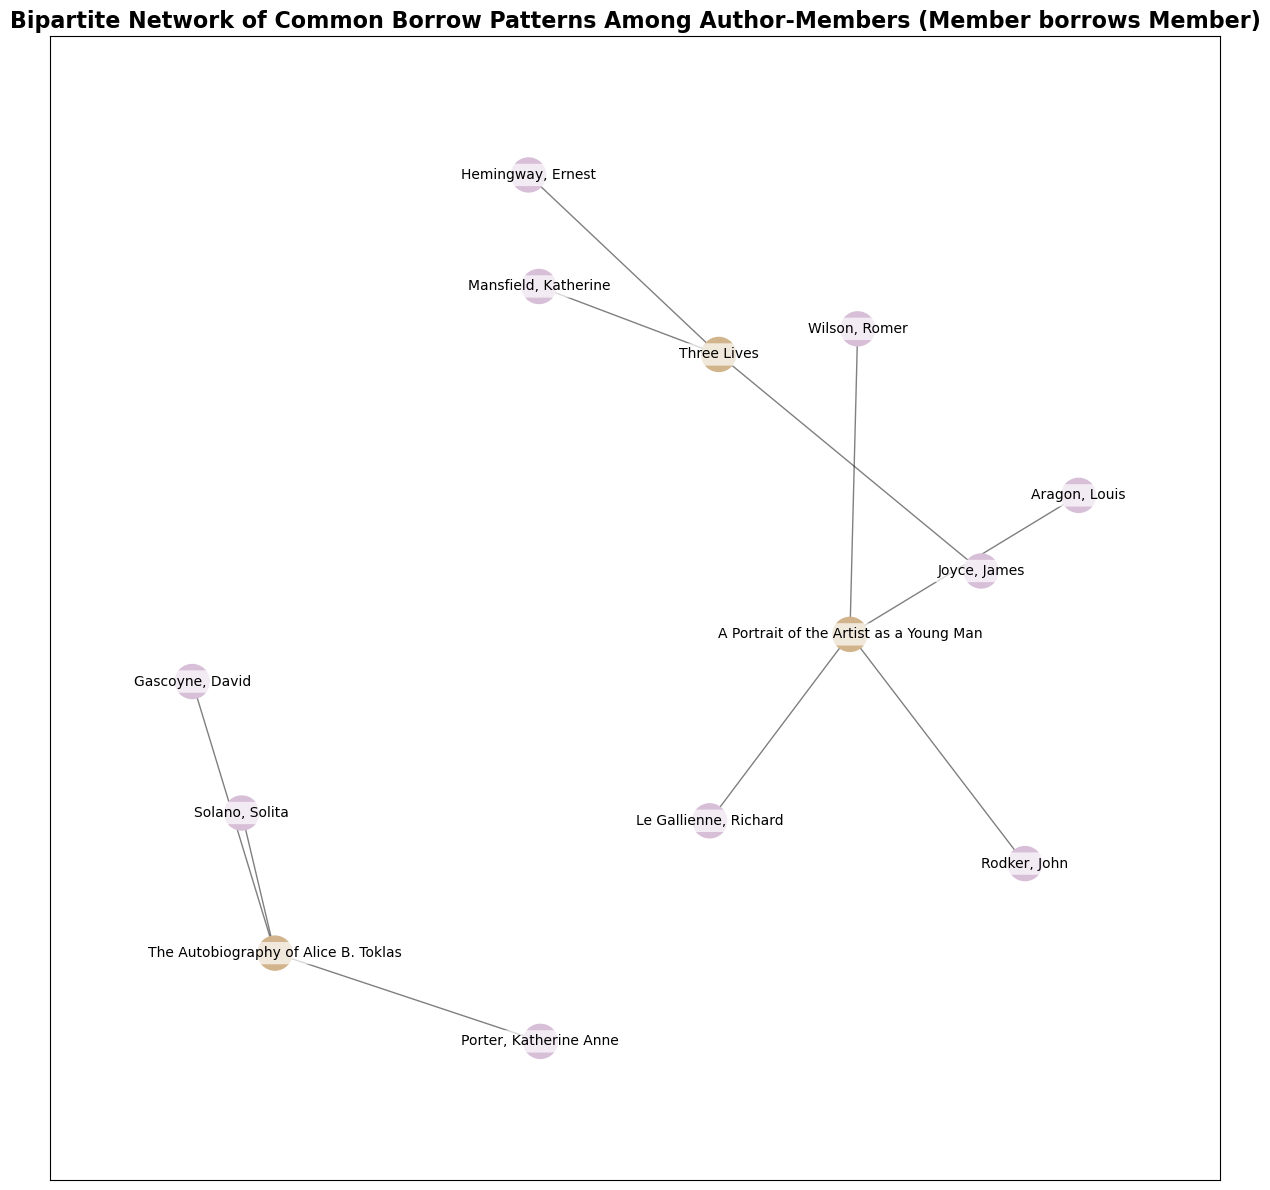

In [55]:
# Bipartite graph | Author-Member Borrows Author-Member Book

# Generate the edge list and graph
AM_borrows_AM_edge_list = create_edge_list(AM_borrows_AM_matrix, min_borrow_count=2)
AM_borrows_AM_edge_graph = build_graph(AM_borrows_AM_edge_list)

# Generate node colors
AM_borrows_AM_node_colors = assign_node_colors(
    AM_borrows_AM_edge_graph, 
    item_nodes=set(AM_borrows_AM_edge_list['item_title'].unique()), 
    item_color='tan', 
    member_color='thistle'
)

plot_network(
    AM_borrows_AM_edge_graph, 
    use_weight=False,  # Set to True if edge weights are to be used; for this graph, we only need the structure
    k=0.88,  # Adjust as necessary for optimal layout
    titleAdd='Bipartite Network of Borrow Patterns Among Author-Members (Author-Member Borrows Author-Member Book)', 
    node_color=AM_borrows_AM_node_colors,  # Pass the computed node colors
    figure_name='AM_borrows_AM_bipartite'
)